# Gather insights from the experiments run on GCP

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Read the experiments file

In [2]:
experiment_file = './100experiments.pkl'
df = pd.read_pickle(experiment_file)

df.head()



,id,model_type,batch_size,epochs,dataset,lr,function_name,default_parallelism,static_parallelism,validate_every,k,goal_accuracy,validation_loss,accuracy,train_loss,parallelism,epoch_duration
0,00016a6d,example,32,5,mnist,0.01,lenet,8,True,1,2,100,"[2.1973181882986244, 1.1784593651469903, 1.029...","[40.84, 61.44, 67.87, 71.9, 74.41, 74.41]","[2.274835508236346, 1.649385466371889, 1.06358...","[8, 8, 8, 8, 8]","[20.341937384, 18.199299126, 19.499556016, 16...."
1,02bee949,example,256,5,mnist,0.01,lenet,8,True,1,-1,100,"[2.286003202199936, 2.239145827293396, 1.84514...","[31.07, 34.76, 47.44, 65.17, 75.72, 75.72]","[2.2961234539747237, 2.272776414950689, 2.1365...","[8, 8, 8, 8, 8]","[8.504620223, 4.627196077, 4.501738296, 4.2119..."
2,041d0a43,example,256,5,mnist,0.01,lenet,1,True,1,8,100,"[1.455910474061966, 0.6767568618059159, 0.3643...","[54.56, 75.22, 86.61, 87.67, 88.19, 88.19]","[1.8920634332630368, 0.8980419049660365, 0.584...","[1, 1, 1, 1, 1]","[21.382301983, 21.158918694, 22.514624452, 25...."
3,05ef4081,example,128,5,mnist,0.01,lenet,6,True,1,-1,100,"[1.999684738207467, 0.8710694237600399, 0.3453...","[41.58, 73.5, 90.54, 95.6, 96.3, 96.3]","[2.2536008035634927, 1.3901311563623941, 0.596...","[6, 6, 6, 6, 6]","[8.202431631, 10.277207753999999, 10.47414276,..."
4,0741fb85,example,256,5,mnist,0.01,lenet,8,True,1,64,100,"[2.3002407133579252, 2.2971227765083313, 2.291...","[10.28, 10.29, 12.36, 14.23, 14.63, 14.63]","[2.3015892674525578, 2.298999429742495, 2.2951...","[8, 8, 8, 8, 8]","[7.473797848, 4.280385144, 4.659832883, 4.3311..."


### Create new columns for representation

- Final accuracy
- Total time taken
- Parallelism

In [3]:
# Set the acc to the final accuracy
df['acc'] = df.accuracy.map(lambda a: a[-1])

# Set the time to the sum of the epoch durations
df['time'] = df.epoch_duration.map(sum)

# Set the parallelism to the first since it is constant
df.parallelism = df.parallelism.map(lambda l:l[0])

# change -1 to inf so the order is right in the plot
df.k = df.k.map(lambda val: float('inf') if val == -1 else val)


In [4]:
from typing import List

def accum_time(durations: List[float]):
    # print('before', durations)
    for i in range(1, len(durations)):
        durations[i] += durations[i-1]
    return durations
        
df.epoch_duration.map(lambda durs: accum_time(durs))
        

0     [20.341937384, 38.541236510000005, 58.04079252...
1     [8.504620223, 13.1318163, 17.633554596, 21.845...
2     [21.382301983, 42.541220677, 65.055845129, 90....
3     [8.202431631, 18.479639385, 28.953782144999998...
4     [7.473797848, 11.754182992, 16.414015875, 20.7...
                            ...                        
95    [13.80060439, 23.017119826, 30.306152857999997...
96    [20.487885076, 33.284010195, 45.675402906, 62....
97    [10.800646598, 20.237180422, 28.35235146700000...
98    [9.994333652, 19.057147463, 25.756005469999998...
99    [10.367504324, 21.367741483, 30.461424877, 36....
Name: epoch_duration, Length: 100, dtype: object

### Plot the Correlations between the K, Batch and Parallelism with time and accuracy

In [ ]:
corr = df[['k', 'batch_size', 'parallelism', 'acc', 'time']].corr()
sns.heatmap(corr,
            annot=True
)


### Get the max accuracies and times and check the parameters used

In [ ]:
# get the max accuracies
df[['k', 'parallelism', 'acc', 'time']].loc[df.parallelism >= 4].sort_values(by='acc', ascending=False).head(10)

## Calculate TTA with different accuracies



In [8]:
# Calculate time to accuracy for different accuracies
def tta(acc:int, df: pd.DataFrame):

    res = []
    for _, row in df.iterrows():
        done = False
        dur, accuracy = row.epoch_duration, row.accuracy
        for idx, (t, a) in enumerate(zip(dur, accuracy[:len(dur)])):
            if a >= acc:
                res.append(t)
                done = True
                break

        if not done:
            res.append(np.nan)

    return res

In [15]:

df['tta_95'] = tta(95, df)



df.sort_values('tta_95')


,id,model_type,batch_size,epochs,dataset,lr,function_name,default_parallelism,static_parallelism,validate_every,...,goal_accuracy,validation_loss,accuracy,train_loss,parallelism,epoch_duration,acc,time,tta_90,tta_95
83,d26bf03f,example,32,5,mnist,0.01,lenet,4,True,1,...,100,"[0.10292607633647667, 0.07041365020365764, 0.0...","[96.74, 97.72, 98.1, 98.46, 98.69, 98.69]","[0.629087566103204, 0.1199973800370776, 0.0805...",4,"[10.32526709, 18.848605152, 26.793319092, 34.8...",98.69,42.964120,10.325267,10.325267
49,66d47050,example,64,5,mnist,0.01,lenet,2,True,1,...,100,"[0.11060942608157208, 0.061826164755324396, 0....","[96.41, 98.05, 98.15, 98.39, 98.63, 98.63]","[0.5604856002860878, 0.10562132961024392, 0.07...",2,"[14.746297403, 37.64234764, 52.635753502, 65.3...",98.63,82.002812,14.746297,14.746297
29,419bcd56,example,32,5,mnist,0.01,lenet,2,True,1,...,100,"[0.17406658710429843, 0.059029900857975284, 0....","[95.43, 98.21, 98.29, 98.54, 98.73, 98.73]","[0.8068039657278288, 0.11768194570779086, 0.07...",2,"[16.264284773, 39.565087823, 54.660093239, 71....",98.73,86.893557,16.264285,16.264285
8,0dc83307,example,32,5,mnist,0.01,lenet,2,True,1,...,100,"[0.09055285320316736, 0.058425187083831896, 0....","[97.23, 98.2, 98.42, 98.78, 98.65, 98.65]","[0.42031963104602393, 0.09073004207162938, 0.0...",2,"[16.420068681, 32.189033001, 49.047589318, 62....",98.65,79.060111,16.420069,16.420069
89,eeb44baf,example,32,5,mnist,0.01,lenet,8,True,1,...,100,"[0.22910406498815686, 0.11014689749051719, 0.0...","[93.29, 96.63, 97.59, 98.07, 98.39, 98.39]","[1.182567041634527, 0.22010011421594788, 0.139...",8,"[10.743975843, 16.878279368999998, 23.82004253...",98.39,35.428428,10.743976,16.878279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,f30bf704,example,256,5,mnist,0.01,lenet,2,True,1,...,100,"[2.279031002521515, 1.2781946495175363, 0.6694...","[27.05, 60.78, 82.45, 92.22, 94.16, 94.16]","[2.2936452438433967, 2.041442214449247, 0.8207...",2,"[14.89196145, 35.346955344, 51.335390313000005...",94.16,80.251625,66.505707,NaN
92,f3bfc948,example,64,5,mnist,0.01,lenet,4,True,1,...,100,"[1.2649675668424862, 0.5818309753563753, 0.557...","[56.18, 76.54, 77.12, 77.19, 77.41, 77.41]","[1.7007387750922474, 0.8153636388265234, 0.596...",4,"[10.605140908, 18.366917311999998, 24.61664449...",77.41,37.790345,NaN,NaN
93,f5d666dc,example,256,5,mnist,0.01,lenet,4,True,1,...,100,"[2.2895358562469483, 2.2524772465229033, 1.874...","[28.01, 30.72, 42.67, 62.72, 64.14, 64.14]","[2.2971765839805207, 2.2748339533184967, 2.126...",4,"[11.252547062, 20.738763149, 29.68315434099999...",64.14,47.925944,NaN,NaN
95,f7733184,example,64,5,mnist,0.01,lenet,8,True,1,...,100,"[1.4588187522948928, 0.7854528687182506, 0.453...","[45.1, 73.47, 83.86, 85.64, 86.25, 86.25]","[2.0253294189056503, 1.097543101261815, 0.7000...",8,"[13.80060439, 23.017119826, 30.306152857999997...",86.25,48.214698,NaN,NaN


<AxesSubplot:xlabel='k', ylabel='tta_95'>

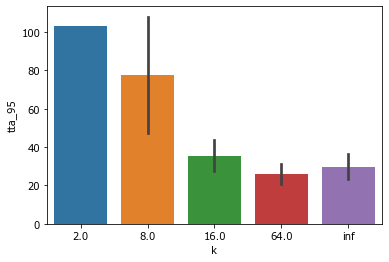

In [16]:
sns.barplot(x='k', y='tta_95', data=df)

In [ ]:
df.head(10)

### Plot the distributions of time and accuracy as a function of K, Batch and parallelism

#### Plot the accuracy as a factor

<AxesSubplot:xlabel='parallelism', ylabel='acc'>

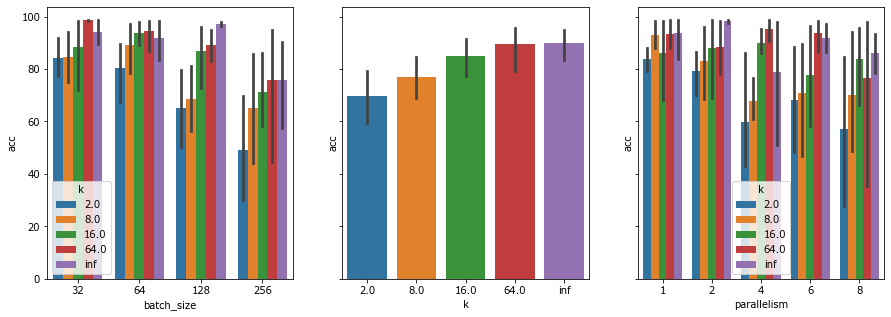

In [13]:
f, ax = plt.subplots(1, 3, sharey=True, figsize=(15, 5))
sns.barplot(x='batch_size', y='acc', hue='k', data=df, ax=ax[0])
sns.barplot(x='k', y='acc', data=df, ax=ax[1])
sns.barplot(x='parallelism', y='acc', data=df, hue='k' ,ax=ax[2])

# plt.savefig('./figures/accuracy.png', dpi=300)

#### Plot the time as a factor

<AxesSubplot:xlabel='parallelism', ylabel='time'>

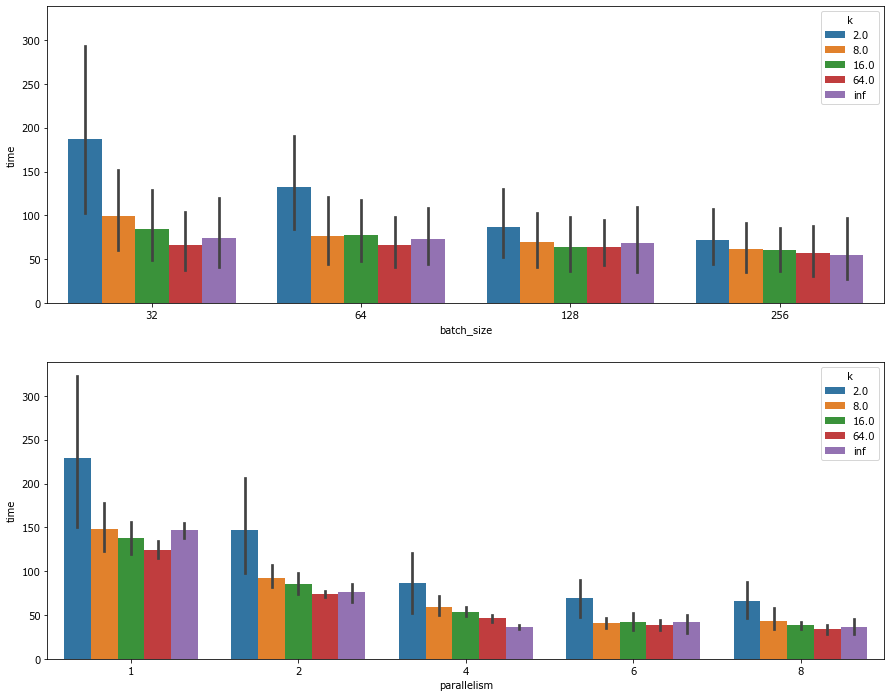

In [12]:
f, ax = plt.subplots(2, 1, sharey=True, figsize=(15, 12))
sns.barplot(x='batch_size', y='time', hue='k', data=df, ax=ax[0])
# sns.barplot(x='k', y='time', data=df, ax=ax[1])
sns.barplot(x='parallelism', y='time', data=df, ax=ax[1], hue='k')

# plt.savefig('./figures/time.png', dpi=300)

## Plot the Accuracy progression varying K and parallelism

#### Keep K and Batch set, vary parallelism

In [ ]:
# Plot the validation lines of k=-1 and batch = 32 with different parallelism
def plot_loss_with_k_and_batch(k: int, batch:int, ax: plt.Axes = None):
    d = df.loc[(df.k==k) & (df.batch_size==batch)].sort_values(by='parallelism', ascending=False)

    plt.rc('font', size=13)
    if ax is None:
        f = plt.figure(figsize=(10, 5))
        for _, row in d.iterrows():
#             print(row.accuracy)
            plt.plot(range(1,6), row.accuracy[:-1] if len(row.accuracy) == 6 else row.accuracy, label=str(row.parallelism))
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title(f'Accuracy evolution with LeNet (batch={batch}, k={k})')
        plt.legend(title='parallelism', bbox_to_anchor=(1.05, 0.8))
        
    else:
        for _, row in d.iterrows():
#             print(row.accuracy)
            ax.plot(range(1,6), row.accuracy[:-1] if len(row.accuracy) == 6 else row.accuracy, label=str(row.parallelism))
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy (%)')
        ax.set_title(f'Batch={batch}, k={k}')
        ax.legend(title='parallelism')
        

f, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15), sharex=True)

plt.suptitle('Behavior of K, Parallelism and Batch in Accuracy')

plot_loss_with_k_and_batch(k=2, batch=32, ax=axes[0][0])
plot_loss_with_k_and_batch(k=16, batch=32, ax=axes[0][1])   
plot_loss_with_k_and_batch(k=64, batch=32, ax=axes[0][2])

plot_loss_with_k_and_batch(k=2, batch=64, ax=axes[1][0])
plot_loss_with_k_and_batch(k=16, batch=64, ax=axes[1][1])   
plot_loss_with_k_and_batch(k=64, batch=64, ax=axes[1][2])

plot_loss_with_k_and_batch(k=2, batch=128, ax=axes[2][0])
plot_loss_with_k_and_batch(k=16, batch=128, ax=axes[2][1])   
plot_loss_with_k_and_batch(k=64, batch=128, ax=axes[2][2])


plt.savefig('./figures/accuracy_study.png', dpi=300)


#### Keep Parallelism and batch set, vary K

In [ ]:
# Plot the validation lines of k=-1 and batch = 32 with different parallelism
def plot_loss_with_parallelism_and_batch(p: int, batch:int, ax: plt.Axes = None):
    d = df.loc[(df.parallelism==p) & (df.batch_size==batch)].sort_values(by='k', ascending=False)
    
    approx_k = (60000/p)/batch

    plt.rc('font', size=16)
    if ax is None:
        f = plt.figure(figsize=(10, 5))
        for _, row in d.iterrows():
#             print(row.accuracy)
            plt.plot(range(1,6), row.accuracy[:-1] if len(row.accuracy) == 6 else row.accuracy, label=str(row.k))
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title(f'Accuracy evolution with LeNet (batch={batch}, k={k})')
        plt.legend(title='parallelism', bbox_to_anchor=(1.05, 0.8))
        
    else:
        for _, row in d.iterrows():
            label = str(row.k) if row.k != float('inf') else f'{row.k} ({int(approx_k)})'
            ax.plot(range(1,6), row.accuracy[:-1] if len(row.accuracy) == 6 else row.accuracy, label=label)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy (%)')
        ax.set_title(f'Batch={batch}, Parallelism={p}')
        ax.legend(title='k')
        

f, axes = plt.subplots(nrows=3, ncols=3, figsize=(30, 20), sharex=True)

plt.suptitle('Behavior of K, Parallelism and Batch in Accuracy')

plot_loss_with_parallelism_and_batch(p=2, batch=32, ax=axes[0][0])
plot_loss_with_parallelism_and_batch(p=4, batch=32, ax=axes[0][1])   
plot_loss_with_parallelism_and_batch(p=8, batch=32, ax=axes[0][2])

plot_loss_with_parallelism_and_batch(p=2, batch=64, ax=axes[1][0])
plot_loss_with_parallelism_and_batch(p=4, batch=64, ax=axes[1][1])   
plot_loss_with_parallelism_and_batch(p=8, batch=64, ax=axes[1][2])

plot_loss_with_parallelism_and_batch(p=2, batch=128, ax=axes[2][0])
plot_loss_with_parallelism_and_batch(p=4, batch=128, ax=axes[2][1])   
plot_loss_with_parallelism_and_batch(p=8, batch=128, ax=axes[2][2])


plt.savefig('./figures/accuracy_study_varying_k.png', dpi=300)

#### Plot 3d dependencies between K and parallelism on time and accuracy

In [ ]:
# f, ax = plt.subplots(1, 2, projection='3d')

f = plt.figure()
ax = f.add_subplot(1, 2, 1, projection='3d')

from scipy.interpolate import griddata
X, Y = np.meshgrid(df.k.map(lambda v: 500 if v == float('inf') else v), df.parallelism)
Z = griddata((df.k.map(lambda v: 500 if v == float('inf') else v),
              df.parallelism),
              df.acc, (X, Y), method='cubic')

ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='coolwarm',
                       linewidth=0, antialiased=False)


In [ ]:
d = df.loc[df.batch==64]